<a href="https://colab.research.google.com/github/RReed637/Brain-Tumor-Detection/blob/main/TumorDetectionModelUsingYolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-cv
!pip install ultralytics
!pip install segmentation_models
!pip install cv2
!pip install torch



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.2/716.2 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.6 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [ ]:
import os
import pickle
import tensorflow as tf
from ultralytics import YOLO
os.environ["KERAS_BACKEND"] = "jax"

from keras_cv.src import bounding_box
from keras_cv.src import layers
import keras_cv
from keras.optimizers import AdamW
from tensorflow.keras.models import load_model
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import cv2


import pandas as pd
import os

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


BATCH_SIZE = 15
GLOBAL_CLIPNORM = 10

AUTO = tf.data.AUTOTUNE

Wed Feb 28 16:19:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              49W / 400W |   8709MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### **ONLY RUN THE FOLLOWING TWO CELLS IF YOU NEED TO RECREATE THE PICKLE FILES AS THIS IS TIME INTENSIVE!!!**

In [ ]:
'''Converts given text files to lists'''
def list_annotation(image_path, text_path):
  img = cv2.imread(image_path)
  width = int(img.shape[0])
  height = int(img.shape[1])

  file_label = open(text_path, "r")
  lines = file_label.read().split('\n')


  boxes = []
  classes = []

  if lines[0] == '':
    return image_path, classes, boxes

  else:
    for i in range(0, int(len(lines))):
      objbud = lines[i].split(' ')
      fclass = int(objbud[0])

      x1 = float(objbud[1])
      y1 = float(objbud[2])
      w1 = float(objbud[3])
      h1 = float(objbud[4])

      xmin = int((x1*width)-(w1*width)/2.0)
      ymin = int((y1*height)-(h1*height)/2.0)
      xmax = int((x1*width)+(w1*width)/2.0)
      ymax = int((y1*height)+(h1*height)/2.0)

      boxes.append([xmin, ymin, xmax, ymax])
      classes.append(fclass)

  return image_path, classes, boxes
# Function creating list of file paths
def paths_list(path):
  complete_path = []
  images = sorted(os.listdir(path))

  for i in images:
    complete_path.append(os.path.join(path, i))

  return complete_path

classids = ['Label0', 'Label1', 'Label2']

mapping = dict(zip(range(len(classids)), classids))

mapping

def making_files(img_files_paths, annot_files_paths):
  image_files = paths_list(img_files_paths)
  annot_files = paths_list(annot_files_paths)

  image_path = []
  bbox = []
  classes = []

  for i in range(0,len(image_files)):
    image_path_, classes_, bbox_ = list_annotation(
        image_files[i],
        annot_files[i]
        )
    image_path.append(image_path_)
    bbox.append(bbox_)
    classes.append(classes_)

  image_path = tf.ragged.constant(image_path)
  bbox = tf.ragged.constant(bbox)
  classes = tf.ragged.constant(classes)

  return image_path, classes, bbox



In [ ]:
# Function application

# Check if the pickle files already exist
training_pickle_path = '/content/drive/MyDrive/Brain-Tumor-Detection/data/training_data.pkl'
valid_pickle_path = '/content/drive/MyDrive/Brain-Tumor-Detection/data/valid_data.pkl'
testing_pickle_path = '/content/drive/MyDrive/Brain-Tumor-Detection/data/Testing_data.pkl'

if not (os.path.exists(training_pickle_path) and os.path.exists(valid_pickle_path) and os.path.exists(testing_pickle_path)):
    # If any of the pickle files do not exist, execute the code to create them
    training_image_paths, training_classes, training_bboxes = making_files(
        '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/train/images',
        '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/train/labels'
    )

    with open(training_pickle_path, 'wb') as f:
        pickle.dump([training_image_paths, training_classes, training_bboxes], f)

    valid_image_paths, valid_classes, valid_bboxes = making_files(
        '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/valid/images',
        '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/valid/labels'
    )

    with open(valid_pickle_path, 'wb') as f:
        pickle.dump([valid_image_paths, valid_classes, valid_bboxes], f)

    testing_image_paths, testing_classes, testing_bboxes = making_files(
        '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/test/images',
        '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/test/labels'
    )
    with open(testing_pickle_path, 'wb') as f:
      pickle.dump([testing_image_paths, testing_classes, testing_bboxes], f)
else:
  print("Pickle files already exist. Skipping the process.")

In [ ]:
def image_preprocessing(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.cast(image, tf.float32)
  return image

sizing = keras_cv.layers.JitteredResize(
    target_size = (640, 640),
    scale_factor=(0.8, 1.25),
    bounding_box_format="xyxy")

def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data


def load_data(image_path,classes,bbox):
        # Preprocess the image data (assuming image_preprocessing is defined somewhere)
        preprocessed_image = image_preprocessing(image_path)

        # Create bounding box dictionary
        bounding_box = {
            "classes": tf.cast(classes, dtype=tf.float32),
            "boxes": bbox
        }

        # Combine image data and bounding box metadata


        return {"images" : preprocessed_image, "bounding_boxes": bounding_box}

In [ ]:

def dict_to_tuple(inputs):
  return inputs["images"], inputs["bounding_boxes"]




In [ ]:

# Model Training
def train_model(model, train_dataset, valid_dataset, epochs):
    model.compile(optimizer=AdamW(learning_rate=0.0001, weight_decay=0.004, global_clipnorm=GLOBAL_CLIPNORM),
                  classification_loss='binary_crossentropy', box_loss='ciou')
    history = model.fit(train_dataset, validation_data=valid_dataset, epochs=epochs)
    return history


In [ ]:

#Model Loading and Saving
def save_model(model, file_path):
    keras.models.save_model(model, file_path)# Load a model


def load_saved_model(file_path):
    return keras.models.load_model(file_path)


In [ ]:

def inspect_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    print("Data loaded from pickle file:")
    print(data)

# Provide the file path of the pickle file you want to inspect
pickle_file_path = '/content/drive/MyDrive/Brain-Tumor-Detection/data/training_data.pkl'
inspect_pickle_file(pickle_file_path)

Data loaded from pickle file:
[<tf.Tensor: shape=(6930,), dtype=string, numpy=
array([b'/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/train/images/volume_100_slice_100_jpg.rf.ac33e0ac3a1eebeb5e262e8a6f7de5d9.jpg', b'/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/train/images/volume_100_slice_101_jpg.rf.1984ae9f91c255104509b3da84cf1be6.jpg',
       b'/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/train/images/volume_100_slice_107_jpg.rf.db31be1f34abd48ca231dc24f59bd81c.jpg', ..., b'/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/train/images/volume_9_slice_89_jpg.rf.9ab5b4f5c8635014475feaec7b805cc9.jpg',
       b'/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/train/images/volume_9_slice_91_jpg.rf.615b98cc69d379faff2fed903e6882f9.jpg', b'/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/train/images/volume_9_slice_99_jpg.rf.14ac88b25a6ec0bc5dfd604483086f68.jpg'], dtype=object)>, <tf.RaggedTensor [[1], [1], [

In [ ]:
strat = tf.distribute.MirroredStrategy()



# Main Function
if __name__ == "__main__":
    # Load data
    training_data = load_pickle('/content/drive/MyDrive/Brain-Tumor-Detection/data/training_data.pkl')
    valid_data = load_pickle('/content/drive/MyDrive/Brain-Tumor-Detection/data/valid_data.pkl')
    testing_data = load_pickle('/content/drive/MyDrive/Brain-Tumor-Detection/data/Testing_data.pkl')

    training_image_paths, training_classes, training_bboxes = training_data
    valid_image_paths, valid_classes, valid_bboxes = valid_data
    testing_image_paths, testing_classes, testing_bboxes = testing_data
    # Create datasets
    train_loader = tf.data.Dataset.from_tensor_slices((training_image_paths, training_classes, training_bboxes))
    train_dataset = (train_loader.map(load_data, num_parallel_calls=AUTO)
                    .shuffle(BATCH_SIZE*10)
                    .ragged_batch(BATCH_SIZE, drop_remainder=True)
                    .map(sizing, num_parallel_calls=AUTO)
                    .map(dict_to_tuple, num_parallel_calls=AUTO)
                    .prefetch(AUTO))

    valid_loader = tf.data.Dataset.from_tensor_slices((valid_image_paths, valid_classes, valid_bboxes))
    valid_dataset = (valid_loader.map(load_data, num_parallel_calls=AUTO)
                    .ragged_batch(BATCH_SIZE, drop_remainder=True)
                    .map(sizing, num_parallel_calls=AUTO)
                    .map(dict_to_tuple, num_parallel_calls=AUTO)
                    .prefetch(AUTO))

    testing_loader = tf.data.Dataset.from_tensor_slices((testing_image_paths, testing_classes, testing_bboxes))
    testing_dataset = (testing_loader.map(load_data, num_parallel_calls=AUTO)
                    .ragged_batch(BATCH_SIZE, drop_remainder=True)
                    .map(sizing, num_parallel_calls=AUTO)
                    .map(dict_to_tuple, num_parallel_calls=AUTO)
                    .prefetch(AUTO))


    # Model Training
    with strat.scope():
        backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone_coco")
        YOLOV8 = keras_cv.models.YOLOV8Detector(num_classes=len(mapping), bounding_box_format="xyxy", backbone=backbone, fpn_depth=1)
    hist = train_model(YOLOV8, train_dataset, valid_dataset, 120)
    # Save Model
    save_model(YOLOV8, '/content/drive/MyDrive/Brain-Tumor-Detection/models/TumorDetectionmodel.keras')

#plot loss



Epoch 1/120
462/462 [==============================] - 94s 110ms/step - loss: 756.3102 - box_loss: 3.2720 - class_loss: 753.0383 - val_loss: 369.1232 - val_box_loss: 2.8836 - val_class_loss: 366.2396
Epoch 2/120
462/462 [==============================] - 48s 104ms/step - loss: 194.9487 - box_loss: 2.7066 - class_loss: 192.2422 - val_loss: 152.4620 - val_box_loss: 2.7714 - val_class_loss: 149.6905
Epoch 3/120
462/462 [==============================] - 48s 103ms/step - loss: 66.9600 - box_loss: 2.6047 - class_loss: 64.3554 - val_loss: 34.2431 - val_box_loss: 2.5985 - val_class_loss: 31.6446
Epoch 4/120
462/462 [==============================] - 48s 103ms/step - loss: 24.2187 - box_loss: 2.5639 - class_loss: 21.6548 - val_loss: 12.9635 - val_box_loss: 2.5332 - val_class_loss: 10.4303
Epoch 5/120
462/462 [==============================] - 48s 103ms/step - loss: 13.6507 - box_loss: 2.5082 - class_loss: 11.1424 - val_loss: 7.3369 - val_box_loss: 2.5466 - val_class_loss: 4.7903
Epoch 6/120
46

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


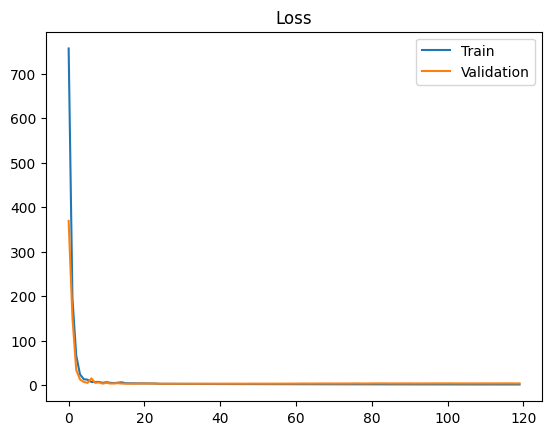

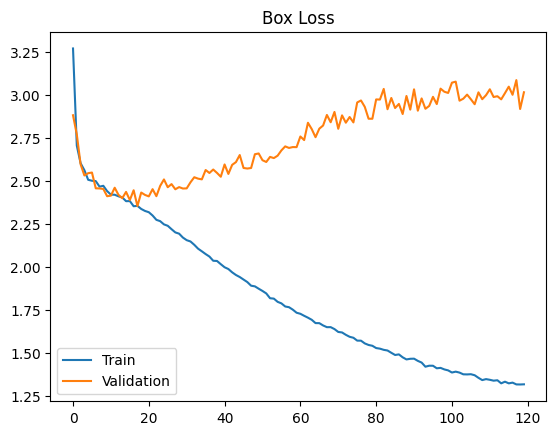

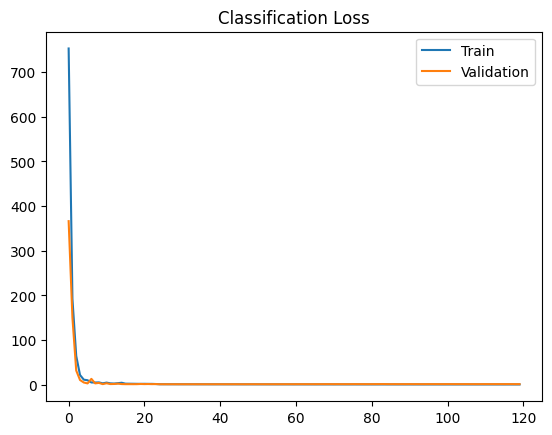

<Figure size 640x480 with 0 Axes>

In [ ]:
#plot loss
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label = 'Validation')
plt.legend()
plt.title('Loss')
plt.show()
plt.savefig('/content/drive/MyDrive/Brain-Tumor-Detection/reports/figures/Loss')
#plot Accuracy
plt.plot(hist.history['box_loss'], label='Train')
plt.plot(hist.history['val_box_loss'], label = 'Validation')
plt.legend()
plt.title('Box Loss')
plt.show()
plt.savefig('/content/drive/MyDrive/Brain-Tumor-Detection/reports/figures/Box Loss')

#plot classification loss
plt.plot(hist.history['class_loss'], label='Train')
plt.plot(hist.history['val_class_loss'], label = 'Validation')
plt.legend()
plt.title('Classification Loss')
plt.show()
plt.savefig('/content/drive/MyDrive/Brain-Tumor-Detection/reports/figures/Classification Loss')


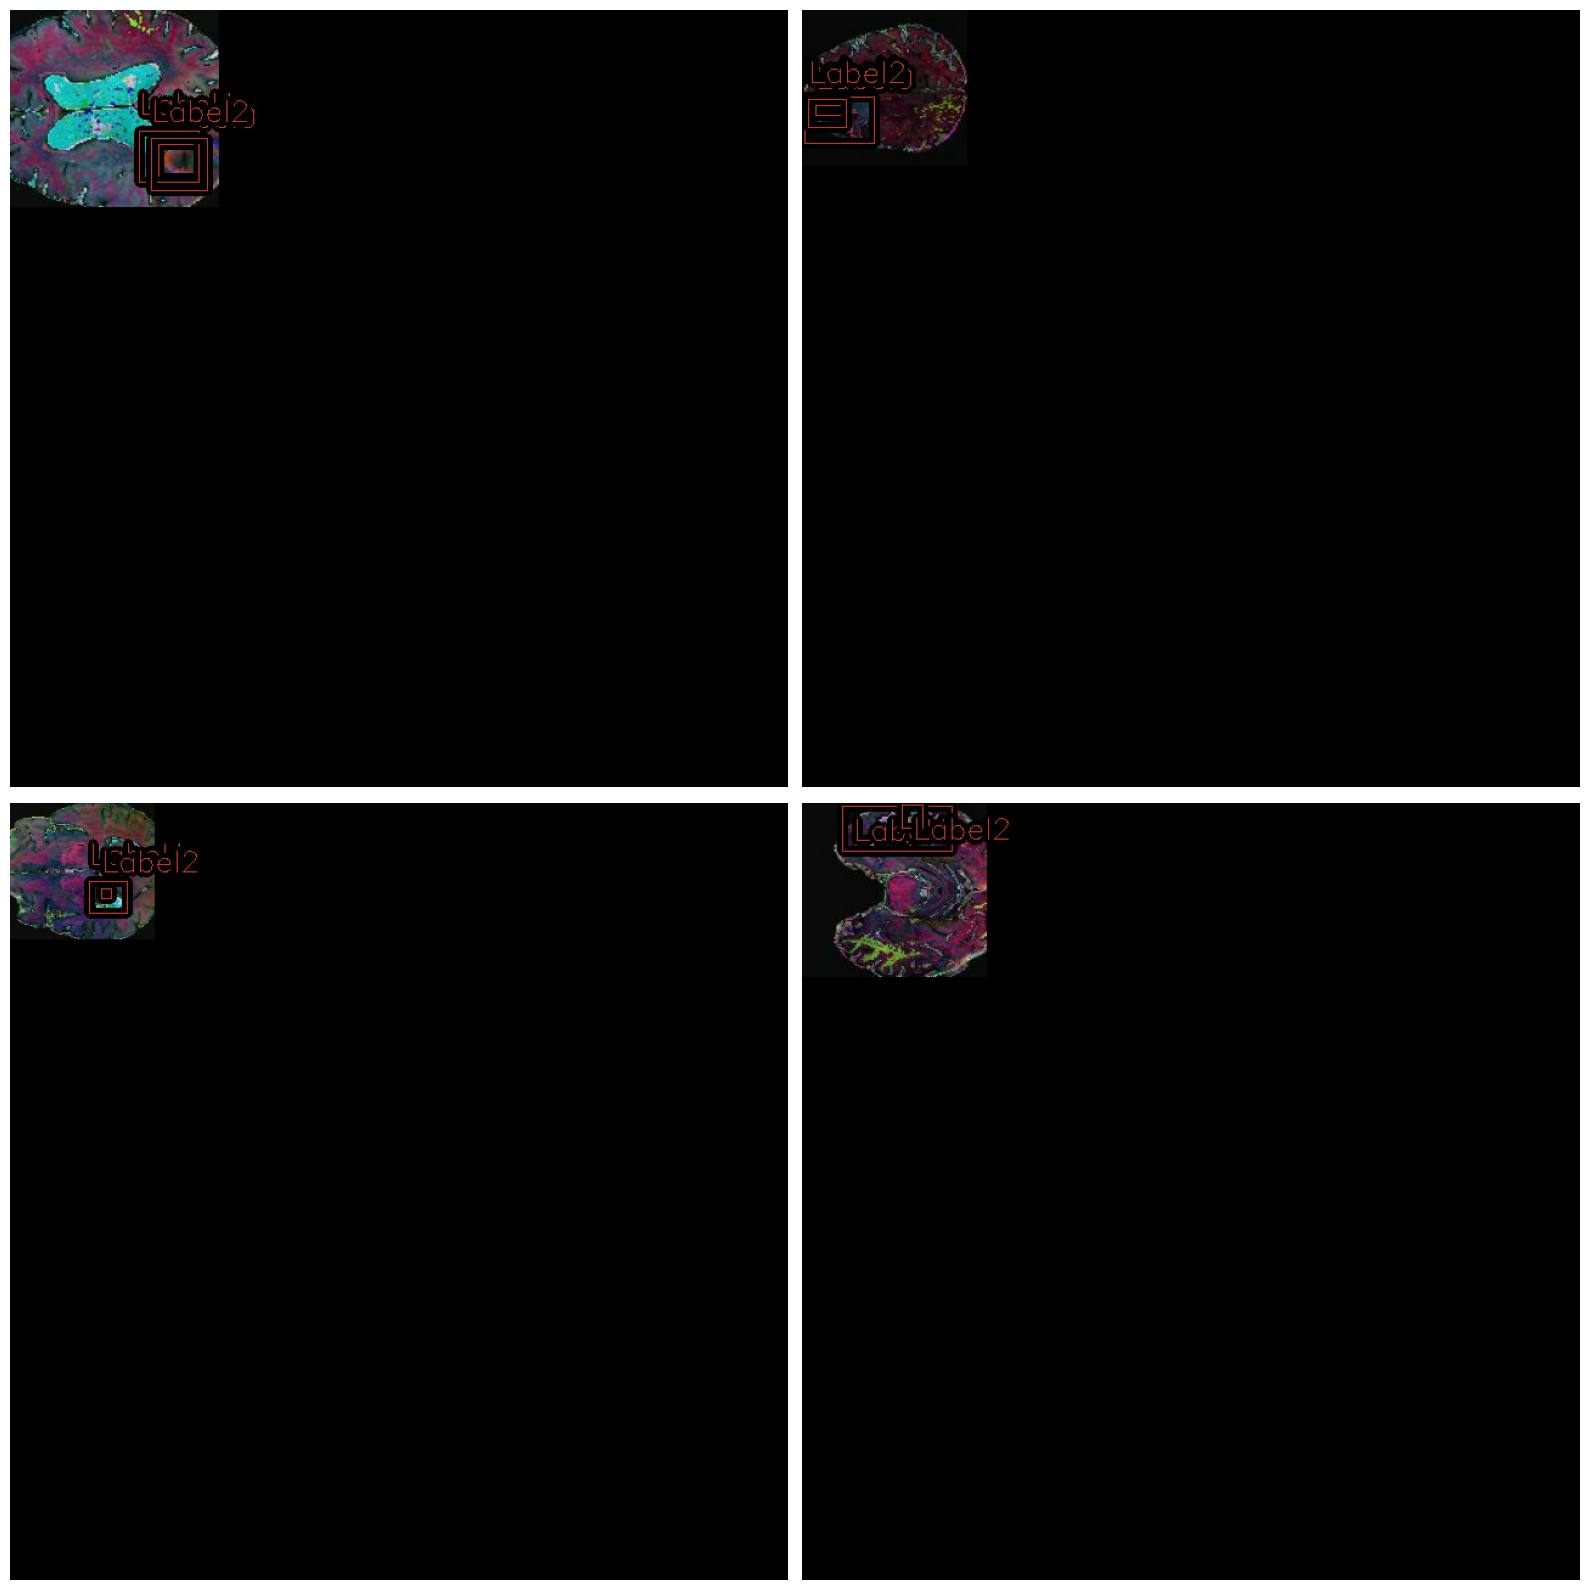

In [ ]:
def visualize(inputs, value_range, rows, cols, bounding_box_format):
  inputs =next(iter(inputs.take(1)))
  image, bounding_boxes = inputs[0], inputs[1]

  keras_cv.visualization.plot_bounding_box_gallery(
      image,
      value_range=value_range,
      rows=rows,
      cols=cols,
      y_true=bounding_boxes,
      scale=8,
      font_scale=0.8,
      line_thickness=1,
      dpi = 300,
      bounding_box_format=bounding_box_format,
      class_mapping=mapping,
      true_color = (192, 57, 43)
  )


visualize(train_dataset,
            bounding_box_format = "xyxy",
            value_range=(0,255),
            rows=2,
            cols=2)

In [ ]:
6891
model = load_saved_model('/content/drive/MyDrive/Brain-Tumor-Detection/models/TumorDetectionmodel.keras')
print(model.summary())

Model: "yolov8_detector_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, None, None, 3)]      0         []                            
                                                                                                  
 model_12 (Functional)       {'P3': (None, None, None,    1277680   ['input_26[0][0]']            
                             64),                                                                 
                              'P4': (None, None, None,                                            
                             128),                                                                
                              'P5': (None, None, None,                                            
                             256)}                                               

1/1 [==============================] - 2s 2s/step


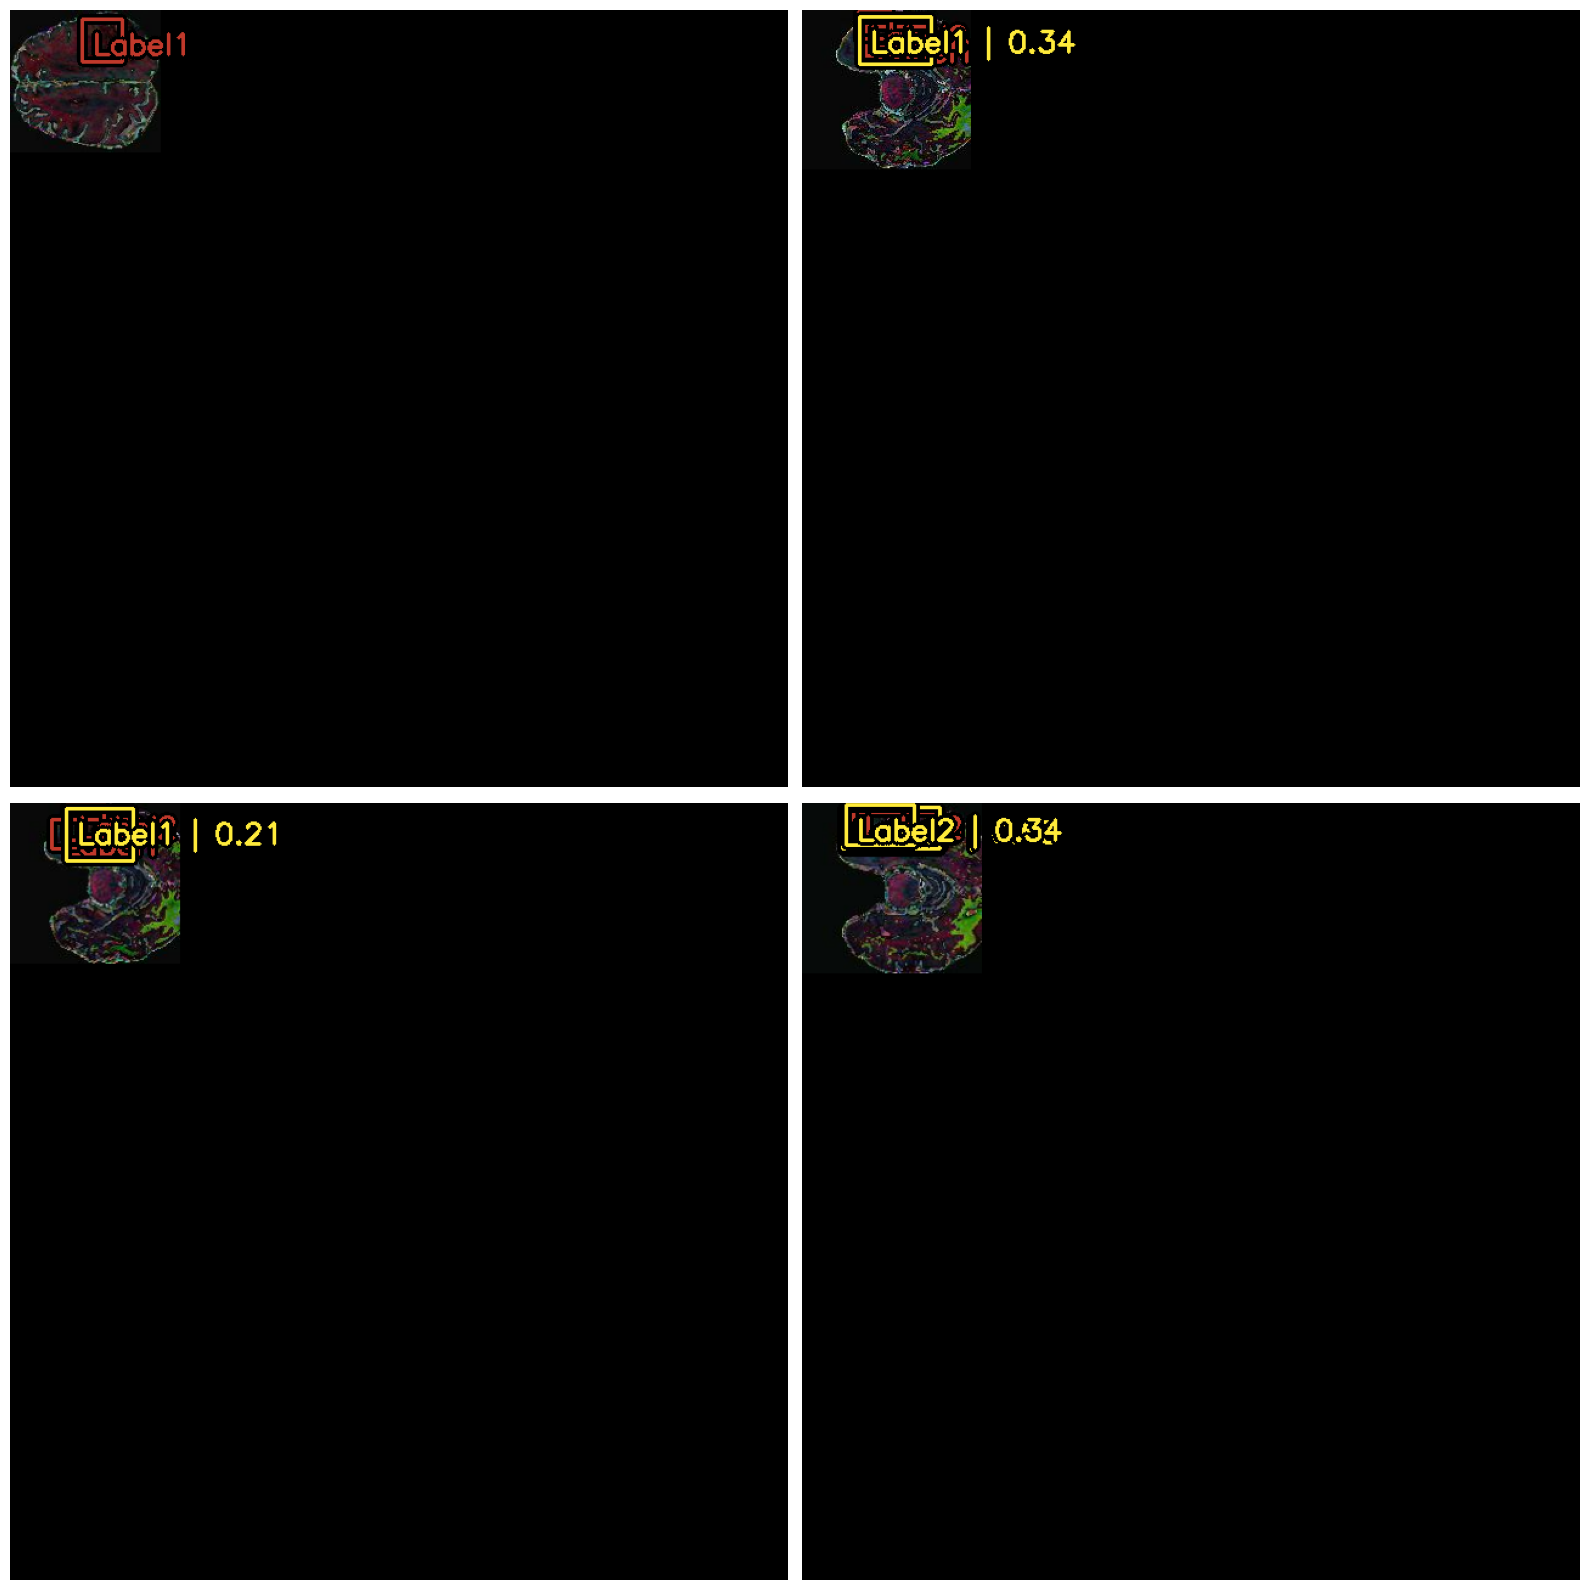

In [ ]:
import matplotlib.pyplot as plt


model.compile(optimizer=AdamW(learning_rate=0.0001, weight_decay=0.004, global_clipnorm=GLOBAL_CLIPNORM),
                  classification_loss='binary_crossentropy', box_loss='ciou')

def visualize_predict_detections(model, dataset, bounding_box_format, num_images=10, show=True, save_filename=None):
    images, y_true = next(iter(dataset.take(num_images)))

    y_pred = model.predict(images)
    y_pred = keras_cv.bounding_box.to_ragged(y_pred)

    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color=(192, 57, 43),
        pred_color=(255, 235, 59),
        scale=8,
        font_scale=0.8,
        line_thickness=2,
        dpi=100,
        rows=2,
        cols=2,
        show=show,
        class_mapping=mapping,
    )

    if save_filename:
        plt.savefig(save_filename)
    if show:
        plt.show()

# Example usage
visualize_predict_detections(model, dataset=testing_dataset, bounding_box_format="xyxy", num_images=4, show=False, save_filename="/content/drive/MyDrive/Brain-Tumor-Detection/reports/figures/detections.png")